<a href="https://colab.research.google.com/github/akiddd37/AI-Group-Project-Oct-25/blob/main/AIProject(mobilenetv3)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/AI Oct 25

Mounted at /content/drive/
/content/drive/My Drive/AI Oct 25


In [ ]:
import os
import shutil
import random
import glob

# 1. Setup paths
os.chdir('/content/drive/My Drive/AI Oct 25/dataset/full')

# 2. Define all the classes (Easier to manage than copy-pasting code)
classes = ['bear', 'deer', 'eagle', 'elephant', 'fox',
           'horse', 'monkey', 'owl', 'parrot', 'tiger']

# 3. Loop through each class
for class_name in classes:
    print(f"Processing {class_name}...")

    # Create directories
    os.makedirs(f'train/{class_name}', exist_ok=True)
    os.makedirs(f'valid/{class_name}', exist_ok=True)
    os.makedirs(f'test/{class_name}', exist_ok=True)

    # A. GET ALL FILES ONCE
    # This finds all files starting with the class name (e.g., "bear_01.jpg")
    all_files = glob.glob(f'{class_name}*')

    # B. SHUFFLE ONCE
    random.shuffle(all_files)

    # C. CALCULATE SPLIT POINTS
    n_total = len(all_files)
    if n_total == 0:
        print(f"⚠️ Warning: No images found for {class_name}")
        continue

    n_train = int(n_total * 0.70) # 70%
    n_valid = int(n_total * 0.20) # 20%
    # Remaining 10% goes to test

    # D. SLICE THE LIST
    train_files = all_files[:n_train]
    valid_files = all_files[n_train:n_train + n_valid]
    test_files  = all_files[n_train + n_valid:]

    # E. MOVE THE FILES
    for f in train_files:
        shutil.move(f, f'train/{class_name}')
    for f in valid_files:
        shutil.move(f, f'valid/{class_name}')
    for f in test_files:
        shutil.move(f, f'test/{class_name}')

    print(f"   -> Moved {len(train_files)} Train, {len(valid_files)} Valid, {len(test_files)} Test")

# 4. Clean up
os.chdir('../../') # Go back to original directory
print("✅ Done!")

Processing bear...
   -> Moved 534 Train, 152 Valid, 78 Test
Processing deer...
   -> Moved 737 Train, 210 Valid, 107 Test
Processing eagle...
   -> Moved 646 Train, 184 Valid, 93 Test
Processing elephant...
   -> Moved 634 Train, 181 Valid, 91 Test
Processing fox...
   -> Moved 615 Train, 175 Valid, 89 Test
Processing horse...
   -> Moved 796 Train, 227 Valid, 115 Test
Processing monkey...
   -> Moved 708 Train, 202 Valid, 102 Test
Processing owl...
   -> Moved 692 Train, 197 Valid, 100 Test
Processing parrot...
   -> Moved 801 Train, 229 Valid, 115 Test
Processing tiger...
   -> Moved 808 Train, 231 Valid, 116 Test
✅ Done!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten,BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
import shutil
import os

# 1. Define source (Drive) and destination (Colab Local)
source_dir = '/content/drive/My Drive/AI Oct 25/dataset/full'
local_dir = '/content/fast_dataset'

# 2. Check if already copied to save time
if not os.path.exists(local_dir):
    print("🚀 Copying data to local runtime for speed... (This takes 1-2 mins)")
    shutil.copytree(source_dir, local_dir)
    print("✅ Copy complete! Training will be fast now.")
else:
    print("✅ Data already on local disk.")

# 3. UPDATE PATHS to point to the new local folder
train_path = os.path.join(local_dir, 'train')
valid_path = os.path.join(local_dir, 'valid')
test_path  = os.path.join(local_dir, 'test')



🚀 Copying data to local runtime for speed... (This takes 1-2 mins)
✅ Copy complete! Training will be fast now.


In [ ]:
# --- SETUP GENERATORS (MobileNetV3 Version) ---

# 1. Training Data
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(224, 224),
                         batch_size=32)

# 2. Validation Data
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(224, 224),
                         batch_size=32)

# 3. Test Data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=test_path,
                         target_size=(224, 224),
                         batch_size=32,
                         shuffle=False) # Keep False for Confusion Matrix

Found 6971 images belonging to 10 classes.
Found 1988 images belonging to 10 classes.
Found 1006 images belonging to 10 classes.


In [ ]:
imgs , labels = next(train_batches)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotImages(images_arr, labels_arr=None):
    # Limit to 10 images max so the plot doesn't get too tiny
    count = min(len(images_arr), 10)

    fig, axes = plt.subplots(1, count, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(count):
        img = images_arr[i]
        ax = axes[i]

        # --- FIX COLORS FOR DISPLAY ---
        img_display = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img_display)
        ax.axis('off')

        # Optional: Show the class label if provided
        if labels_arr is not None:
            # Check which index is '1' (e.g., [0, 1, 0, 0...])
            class_index = np.argmax(labels_arr[i])
            ax.set_title(f"Class: {class_index}")

    plt.tight_layout()
    plt.show()

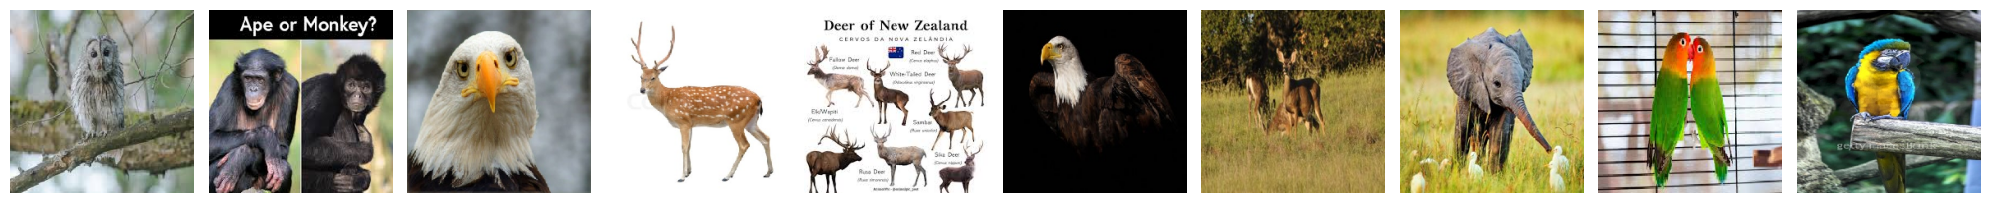

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
# 1. Load MobileNetV3
mobilenet_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,        # Remove the original output layer
    input_shape=(224, 224, 3)
)

# 2. Freeze
mobilenet_model.trainable = False

# 3. Build the Full Model
model = tf.keras.Sequential([

    # Use MobileNet's specific color fixer.
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input, input_shape=(224, 224, 3)),

    # The MobileNet Base
    mobilenet_model,

    # Custom Classifier
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax') # 10 Animal Classes
])

model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,890 (3.60 MB)

 Trainable params: 5,770 (22.54 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Use AUC (Area Under Curve) with curve='PR' (Precision-Recall).
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='PR', name='mAP')
    ]
)

In [ ]:
history1 = model.fit(x=train_batches, steps_per_epoch = len(train_batches), validation_data = valid_batches, validation_steps=len(valid_batches),
         epochs = 50, verbose =2)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 - 54s - 246ms/step - accuracy: 0.3725 - loss: 1.8915 - mAP: 0.3408 - val_accuracy: 0.6801 - val_loss: 1.2884 - val_mAP: 0.7352
Epoch 2/50
218/218 - 14s - 66ms/step - accuracy: 0.8028 - loss: 0.9688 - mAP: 0.8721 - val_accuracy: 0.8627 - val_loss: 0.7390 - val_mAP: 0.9311
Epoch 3/50
218/218 - 17s - 77ms/step - accuracy: 0.8954 - loss: 0.6073 - mAP: 0.9516 - val_accuracy: 0.9029 - val_loss: 0.5184 - val_mAP: 0.9611
Epoch 4/50
218/218 - 17s - 80ms/step - accuracy: 0.9179 - loss: 0.4503 - mAP: 0.9687 - val_accuracy: 0.9215 - val_loss: 0.4096 - val_mAP: 0.9713
Epoch 5/50
218/218 - 21s - 95ms/step - accuracy: 0.9276 - loss: 0.3665 - mAP: 0.9757 - val_accuracy: 0.9266 - val_loss: 0.3480 - val_mAP: 0.9759
Epoch 6/50
218/218 - 14s - 65ms/step - accuracy: 0.9330 - loss: 0.3148 - mAP: 0.9798 - val_accuracy: 0.9311 - val_loss: 0.3072 - val_mAP: 0.9791
Epoch 7/50
218/218 - 14s - 63ms/step - accuracy: 0.9399 - loss: 0.2794 - mAP: 0.9826 - val_accuracy: 0.9331 - val_loss: 0.2787 - val_mAP: 0.

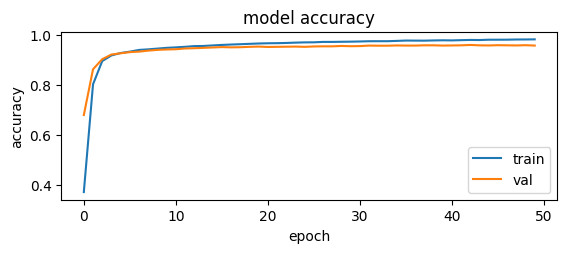

In [ ]:
plt.subplot(2,1,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

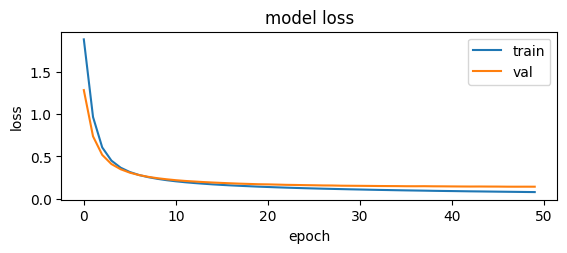

In [ ]:
plt.subplot(2,1,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

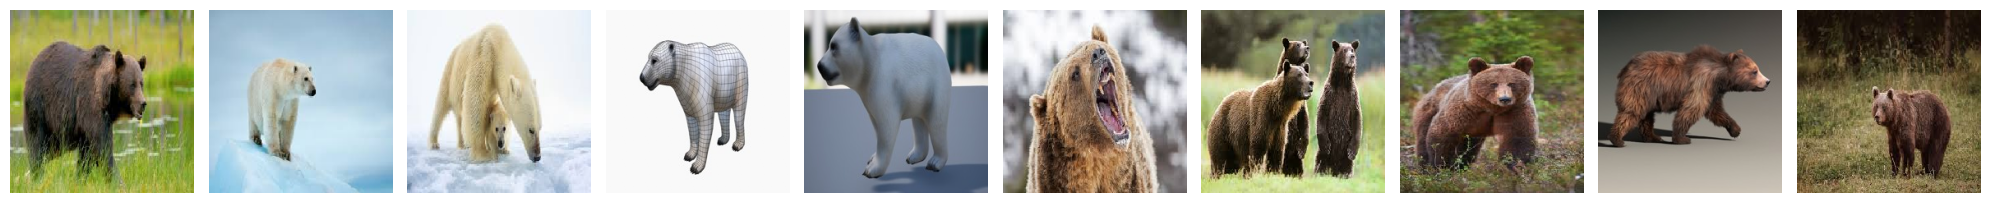

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0.

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
test_batches.class_indices

{'bear': 0,
 'deer': 1,
 'eagle': 2,
 'elephant': 3,
 'fox': 4,
 'horse': 5,
 'monkey': 6,
 'owl': 7,
 'parrot': 8,
 'tiger': 9}

Confusion matrix, without normalization
[[ 76   0   0   1   0   1   0   0   0   0]
 [  0 104   0   0   0   2   0   1   0   0]
 [  0   0  91   0   0   0   0   2   0   0]
 [  0   1   0  88   0   2   0   0   0   0]
 [  1   2   0   0  78   2   0   1   3   2]
 [  0   0   0   0   0 115   0   0   0   0]
 [  1   0   0   0   1   0  97   2   0   1]
 [  0   0   1   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0   1   0 114   0]
 [  0   0   1   0   0   0   0   1   0 114]]


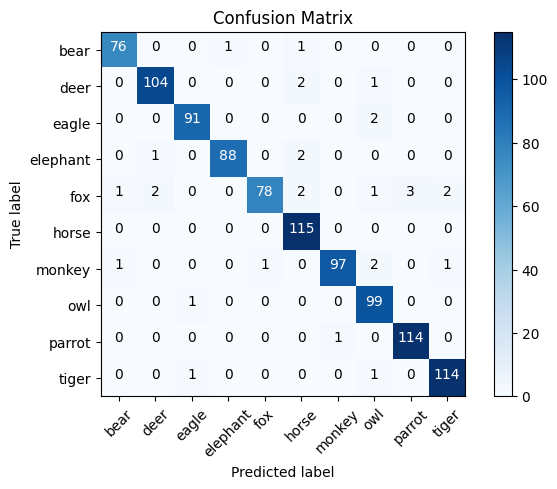

In [ ]:
cm_plot_labels = ['bear','deer','eagle','elephant','fox','horse','monkey','owl','parrot','tiger']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
loss, acc, mAP = model.evaluate(test_imgs, test_labels, batch_size=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9217 - loss: 0.3656 - mAP: 0.9483


In [ ]:
loss, acc, mAP = model.evaluate(test_imgs, test_labels, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9375 - loss: 0.2962 - mAP: 0.9664


# Full Fine Tuning


In [ ]:
# 1. Load MobileNetV3 (The "Fast Brain")
mobilenet_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',       # Pre-trained on 1000 objects
    include_top=False,        # Remove the original output layer
    input_shape=(224, 224, 3)
)

# 2. Unfreeze the Brain
mobilenet_model.trainable = True

# 3. Build the Full Model
model = tf.keras.Sequential([
    # --- CRITICAL CHANGE HERE ---
    # Use MobileNet's specific color fixer.
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input, input_shape=(224, 224, 3)),

    # The MobileNet Base
    mobilenet_model,

    # Your Custom Classifier
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax') # 10 Animal Classes
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,890 (3.60 MB)

 Trainable params: 932,778 (3.56 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
# Use AUC (Area Under Curve) with curve='PR' (Precision-Recall).
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='PR', name='mAP')
    ]
)

In [ ]:
history2 = model.fit(x=train_batches, steps_per_epoch = len(train_batches), validation_data = valid_batches, validation_steps=len(valid_batches),
         epochs = 50, verbose =2)

Epoch 1/50
218/218 - 101s - 465ms/step - accuracy: 0.7072 - loss: 0.9910 - mAP: 0.8018 - val_accuracy: 0.8491 - val_loss: 0.4885 - val_mAP: 0.9266
Epoch 2/50
218/218 - 18s - 80ms/step - accuracy: 0.9218 - loss: 0.2776 - mAP: 0.9747 - val_accuracy: 0.9170 - val_loss: 0.2968 - val_mAP: 0.9716
Epoch 3/50
218/218 - 15s - 70ms/step - accuracy: 0.9508 - loss: 0.1712 - mAP: 0.9896 - val_accuracy: 0.9341 - val_loss: 0.2452 - val_mAP: 0.9791
Epoch 4/50
218/218 - 15s - 67ms/step - accuracy: 0.9713 - loss: 0.1031 - mAP: 0.9964 - val_accuracy: 0.9437 - val_loss: 0.2064 - val_mAP: 0.9837
Epoch 5/50
218/218 - 21s - 97ms/step - accuracy: 0.9811 - loss: 0.0742 - mAP: 0.9982 - val_accuracy: 0.9422 - val_loss: 0.2003 - val_mAP: 0.9835
Epoch 6/50
218/218 - 15s - 67ms/step - accuracy: 0.9890 - loss: 0.0498 - mAP: 0.9993 - val_accuracy: 0.9482 - val_loss: 0.1753 - val_mAP: 0.9866
Epoch 7/50
218/218 - 15s - 69ms/step - accuracy: 0.9927 - loss: 0.0351 - mAP: 0.9997 - val_accuracy: 0.9532 - val_loss: 0.1627 -

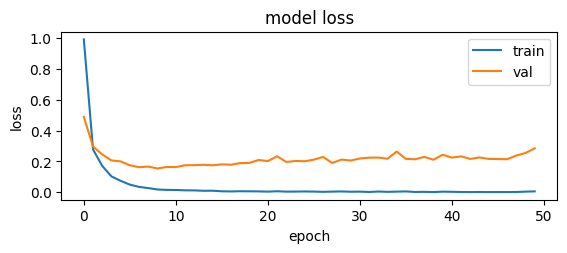

In [ ]:
plt.subplot(2,1,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

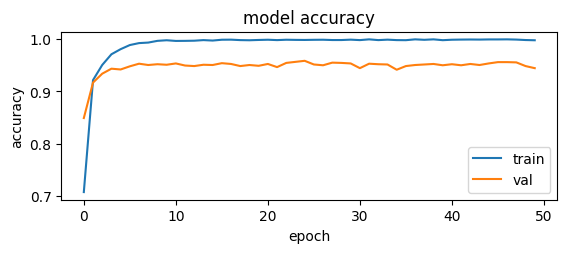

In [ ]:
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

Confusion matrix, without normalization
[[ 76   0   0   1   0   1   0   0   0   0]
 [  0 104   0   0   0   2   0   1   0   0]
 [  0   0  91   0   0   0   0   2   0   0]
 [  0   1   0  88   0   2   0   0   0   0]
 [  1   2   0   0  78   2   0   1   3   2]
 [  0   0   0   0   0 115   0   0   0   0]
 [  1   0   0   0   1   0  97   2   0   1]
 [  0   0   1   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0   1   0 114   0]
 [  0   0   1   0   0   0   0   1   0 114]]


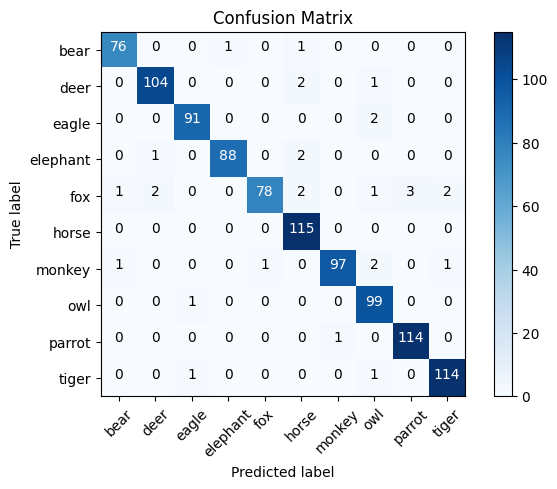

In [ ]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))
cm_plot_labels = ['bear','deer','eagle','elephant','fox','horse','monkey','owl','parrot','tiger']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
loss,acc,mAP = model.evaluate(test_imgs, test_labels, batch_size=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8925 - loss: 0.4189 - mAP: 0.9571
